In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

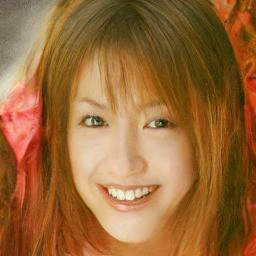

In [6]:
images = image_pipe().images
images[0]

In [7]:
# 创建一个新的调度器，并设置推理迭代次数
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [ ]:
# 随机噪声，batch_size=4，3通道，长宽均为256像素的一组图像
x = torch.randn(4, 3, 256, 256).to(device)

# 循环时间步
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # 给带噪图像加上时间步信息
    model_input = scheduler.scale_model_input(x, t)
    
    # 预测噪声
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    
    # 使用调度器计算更新的样本
    scheduler_output = scheduler.step(noise_pred, t, x)

    # 更新输入图像
    x = scheduler_output.prev_sample
    
    # 绘制输入图像和预测的去噪图像
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

0it [00:00, ?it/s]

In [ ]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

In [ ]:
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

image_size = 256
batch_size = 4
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [ ]:
num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2  

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # 随机生成一个噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        # 随机选取一个时间步
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.conf.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()
        
        # 添加噪声，前向扩散过程
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
        # 使用“带噪”图像进行网络预测
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)

        losses.append(loss.item())
        # 更新梯度
        loss.backward(loss)

        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# 绘制损失曲线
plt.plot(losses)

In [ ]:
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [ ]:
# 加载一个预训练的管线
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# 使用DDIM调度器，用40步生成图片
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# 从随机噪声开始
x = torch.randn(8, 3, 256, 256).to(device)

# 使用一个最简单的采样循环
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# 生成图片
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [ ]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """给定一个RGB值，返回一个损失值，用于衡量图片的像素值与目标颜色之差"""
    # 归一化
    target = torch.tensor(target_color).to(images.device) * 2 - 1  
    # 将目标张量的形状改未(b, c, h, w)
    target = target[None, :, None, None]  
    # 计算图片的像素值以及目标颜色的均方误差
    error = torch.abs(images - target).mean()  
    return error

In [ ]:
# 用于决定引导的强度有多大，可设置5~100之间的数
guidance_loss_scale = 40  

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    x = x.detach().requires_grad_()
    
    # 得到去噪后的图像
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())
    
    # 获取梯度
    cond_grad = -torch.autograd.grad(loss, x)[0]
    # 梯度更新x
    x = x.detach() + cond_grad
    # 使用调度器更新x
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [ ]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224), 
        torchvision.transforms.RandomAffine(5),  
        torchvision.transforms.RandomHorizontalFlip(),  
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# 定义一个损失函数，用于获取图片的特征，然后与提示文字的特征进行对比
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

In [ ]:
prompt = "Red Rose (still life), red flower painting"

guidance_scale = 8  
n_cuts = 4  

scheduler.set_timesteps(50)

# 使用CLIP从提示文字中提取特征
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        x = x.detach().requires_grad_()
        # 获取“去噪”后的图像
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        loss = clip_loss(x0, text_features) * guidance_scale
        # 获取梯度并使用n_cuts平均
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()

    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

In [ ]:
# 加载MNIST数据集
dataset = torchvision.datasets.MNIST(root="./data/mnist/", train=True, 
                                     download=True, 
                                     transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [ ]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()
        
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=28,           
            in_channels=1 + class_emb_size, # 加入额外的输入通道
            out_channels=1,           # 输出结果的通道数
            layers_per_block=2,       # 残差层个数
            block_out_channels=(32, 64, 64), 
            down_block_types=( 
                "DownBlock2D",        # 下采样模块
                "AttnDownBlock2D",    # 含有spatil self-attention的ResNet下采样模块
                "AttnDownBlock2D",
            ), 
            up_block_types=(
                "AttnUpBlock2D", 
                "AttnUpBlock2D",      # 含有spatil self-attention的ResNet上采样模块
                "UpBlock2D",          # 上采样模块
              ),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        # 类别条件将会以额外通道的形式输入
        class_cond = self.class_emb(class_labels) 
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)

        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

        return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epochs = 10

net = ClassConditionedUnet().to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

losses = []

for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        x = x.to(device) * 2 - 1 
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y) 

        loss = loss_fn(pred, noise) 

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)

In [ ]:
# 准备一个随机噪声作为起点，并准备想要的图片标签
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# 循环采样
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, y)

    x = noise_scheduler.step(residual, t, x).prev_sample

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')